In [1]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import os

predictor_path = "shape_predictor_68_face_landmarks.dat"

if not os.path.exists(predictor_path):
    print(f"Shape predictor model not found at {predictor_path}")
    print("Please download it from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2")
    print("Unzip it, and place it in the current directory or update 'predictor_path'.")
else:
    try:
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor(predictor_path)
        print("Dlib face detector and shape predictor loaded successfully.")
    except Exception as e:
        print(f"Error loading Dlib models: {e}")
        print("Ensure the predictor_path is correct and the file is not corrupted.")

# Define landmark indices for eyes and other relevant points
# (based on the 68-point model)
JAWLINE_POINTS = list(range(0, 17))
RIGHT_EYEBROW_POINTS = list(range(17, 22))
LEFT_EYEBROW_POINTS = list(range(22, 27))
NOSE_POINTS = list(range(27, 36))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
MOUTH_OUTLINE_POINTS = list(range(48, 61))
MOUTH_INNER_POINTS = list(range(61, 68))

# Points for head pose estimation (simplified)
NOSE_TIP = 30
CHIN = 8
LEFT_EYE_LEFT_CORNER = 36
RIGHT_EYE_RIGHT_CORNER = 45
LEFT_MOUTH_CORNER = 48
RIGHT_MOUTH_CORNER = 54

Dlib face detector and shape predictor loaded successfully.


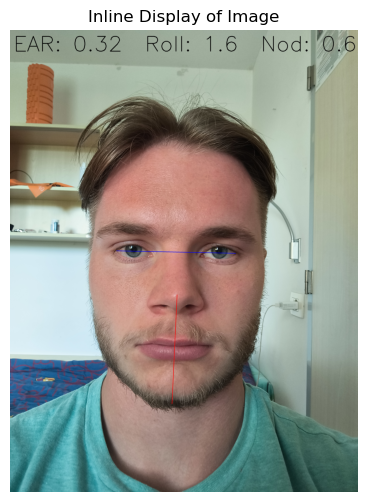

In [2]:
def eye_aspect_ratio(eye_landmarks_np):
    # eye_landmarks_np should be a NumPy array of 6 (x, y)-coordinates
    # Vertical eye landmarks
    A = dist.euclidean(eye_landmarks_np[1], eye_landmarks_np[5])
    B = dist.euclidean(eye_landmarks_np[2], eye_landmarks_np[4])
    # Horizontal eye landmark
    C = dist.euclidean(eye_landmarks_np[0], eye_landmarks_np[3])

    if C == 0: return 0.3 # Avoid division by zero, return a neutral EAR
    ear = (A + B) / (2.0 * C)
    return ear

def get_head_tilt_features(shape, image_size_wh):
    # shape: dlib full_object_detection
    # image_size_wh: (width, height) of the image
    
    # For Roll angle: using the line connecting the outer eye corners
    left_eye_outer_corner = (shape.part(LEFT_EYE_POINTS[0]).x, shape.part(LEFT_EYE_POINTS[0]).y)
    right_eye_outer_corner = (shape.part(RIGHT_EYE_POINTS[3]).x, shape.part(RIGHT_EYE_POINTS[3]).y)

    delta_y_eyes = right_eye_outer_corner[1] - left_eye_outer_corner[1]
    delta_x_eyes = right_eye_outer_corner[0] - left_eye_outer_corner[0]

    roll_angle_deg = 0
    if delta_x_eyes != 0:
        roll_angle_rad = np.arctan(delta_y_eyes / delta_x_eyes)
        roll_angle_deg = np.degrees(roll_angle_rad)
    elif delta_y_eyes != 0: # Eyes are perfectly vertical relative to each other
        roll_angle_deg = 90 if delta_y_eyes > 0 else -90


    # For a simplified Pitch/Nod feature:
    # Ratio of vertical distance (nose tip to chin) to face height (eyebrow to chin)
    # This is a heuristic. More advanced methods use solvePnP.
    try:
        nose_tip_y = shape.part(NOSE_TIP).y
        chin_y = shape.part(CHIN).y
        
        # Estimate face top (e.g., midpoint of eyebrows)
        eyebrow_left_y = min(shape.part(p).y for p in LEFT_EYEBROW_POINTS)
        eyebrow_right_y = min(shape.part(p).y for p in RIGHT_EYEBROW_POINTS)
        face_top_y = (eyebrow_left_y + eyebrow_right_y) / 2.0
        
        face_height = chin_y - face_top_y
        nose_chin_dist = chin_y - nose_tip_y

        nod_feature = 0.5 # Default neutral value
        if face_height > 10: # Avoid division by zero or instability with tiny faces
            nod_feature = nose_chin_dist / face_height
            nod_feature = np.clip(nod_feature, 0, 1) # Keep it in a reasonable range
        
    except Exception: # If any landmark is not found (shouldn't happen with dlib's 68 points if face is found)
        nod_feature = 0.5 # Default if calculation fails

    return roll_angle_deg, nod_feature

# Example usage (requires an image and detected landmarks)
image = cv2.imread("my_data/awake.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)

if len(rects) > 0:
    shape = predictor(gray, rects[0])
    landmarks = np.array([(shape.part(i).x, shape.part(i).y) for i in range(68)])

    # EAR calculation
    left_eye_lm = landmarks[LEFT_EYE_POINTS]
    right_eye_lm = landmarks[RIGHT_EYE_POINTS]
    left_ear = eye_aspect_ratio(left_eye_lm)
    right_ear = eye_aspect_ratio(right_eye_lm)
    avg_ear = (left_ear + right_ear) / 2.0

    # Head tilt
    roll, nod = get_head_tilt_features(shape, gray.shape)

    # Draw landmarks
    for (x, y) in landmarks:
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1)

    # Draw lines between key points for head tilt visualization
    cv2.line(image, tuple(landmarks[LEFT_EYE_LEFT_CORNER]), tuple(landmarks[RIGHT_EYE_RIGHT_CORNER]), (255, 0, 0), 5)
    cv2.line(image, tuple(landmarks[NOSE_TIP]), tuple(landmarks[CHIN]), (0, 0, 255), 5)

    # Display EAR and head pose info
    text = f"EAR: {avg_ear:.2f}  Roll: {roll:.1f}  Nod: {nod:.2f}"
    cv2.putText(image, text, (50, 300), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 0, 0), 10)

    # Show image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the image inline
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.title("Inline Display of Image")
    plt.show()
else:
    print("No faces detected.")

In [3]:
import pandas as pd
from tqdm import tqdm # For progress bars
# train_test_split will not be needed if using predefined splits, but keep for other uses
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# Define labels: 0 for alert, 1 for drowsy
LABEL_DROWSY = 0
LABEL_ALERT = 1

# This function processes a specific split (train, val, or test)
def extract_features_for_split(base_dataset_path, split_name, dlib_detector, dlib_predictor):
    all_features_list = []
    
    # Define mappings from folder names to labels
    category_map = {
        'Drowsy': {'label': LABEL_DROWSY, 'description': 'Drowsy (Eyes Closed)'},
        'Non Drowsy': {'label': LABEL_ALERT, 'description': 'Non Drowsy (Eyes Open)'},
        # 'yawn': {'label': LABEL_DROWSY, 'description': 'Drowsy (Yawning)'}, # Optionally include
        # 'no_yawn': {'label': LABEL_ALERT, 'description': 'Alert (Not Yawning)'} # Optionally include
    }

    # Construct path to the specific split directory containing class folders
    # e.g., dataset_path/splitted_data/train/
    split_data_path = os.path.join(base_dataset_path, 'splitted_data', split_name)

    if not os.path.isdir(split_data_path):
        print(f"Error: Directory for split '{split_name}' not found at: {split_data_path}")
        return pd.DataFrame() # Return empty if the split directory doesn't exist

    print(f"\nProcessing split: '{split_name}' from '{split_data_path}'")
    image_paths_and_labels = []

    for category_folder_name, R_label_info in category_map.items():
        # Path to class folder, e.g., dataset_path/splitted_data/train/OpenFace/
        class_folder_path = os.path.join(split_data_path, category_folder_name)
        if os.path.isdir(class_folder_path):
            print(f"  Loading images from: {class_folder_path}")
            for img_name in os.listdir(class_folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths_and_labels.append({
                        'image_path': os.path.join(class_folder_path, img_name),
                        'label': R_label_info['label']
                    })
        else:
            print(f"  Warning: Class directory not found: {class_folder_path}")

    if not image_paths_and_labels:
        print(f"No images found for split '{split_name}'. Please check the directory structure and image files.")
        return pd.DataFrame()

    print(f"  Found {len(image_paths_and_labels)} images to process for '{split_name}' split.")

    for item in tqdm(image_paths_and_labels, desc=f"Extracting features for {split_name}", leave=False):
        image_path = item['image_path']
        label = item['label']
        
        image = cv2.imread(image_path)
        if image is None:
            # print(f"Warning: Could not read image {image_path}") # Can be verbose
            continue
            
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        face_rects = dlib_detector(gray_image, 0) 

        if len(face_rects) > 0:
            face_rect = face_rects[0] 
            landmarks_shape = dlib_predictor(gray_image, face_rect)
            landmarks_np = np.array([(landmarks_shape.part(i).x, landmarks_shape.part(i).y) for i in range(68)])

            left_eye_lm = landmarks_np[LEFT_EYE_POINTS]
            right_eye_lm = landmarks_np[RIGHT_EYE_POINTS]

            left_ear = eye_aspect_ratio(left_eye_lm)
            right_ear = eye_aspect_ratio(right_eye_lm)
            avg_ear = (left_ear + right_ear) / 2.0

            roll_angle, nod_feature = get_head_tilt_features(landmarks_shape, (image.shape[1], image.shape[0]))

            all_features_list.append({
                'ear': avg_ear,
                'roll': roll_angle,
                'nod': nod_feature,
                'label': label
            })
            
    return pd.DataFrame(all_features_list)


# --- PyTorch Dataset Class (remains the same) ---
class DrowsinessFeatureDataset(Dataset):
    def __init__(self, features_df):
        self.features_df = features_df.astype(np.float32).fillna(0) 
        self.features = torch.tensor(self.features_df.drop('label', axis=1).values, dtype=torch.float32)
        self.labels = torch.tensor(self.features_df['label'].values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# --- Main Data Processing Steps using predefined splits ---
train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
train_loader, val_loader, test_loader = None, None, None # Initialize

if detector and predictor: # Check if Dlib models are loaded
    # dataset_path should point to the root directory containing 'splitted_data'
    # e.g., 'Drowsiness_Detection_Dataset'
    dataset_path = ''

    # Process training data
    print("-" * 30)
    train_df = extract_features_for_split(dataset_path, 'train', detector, predictor)
    if not train_df.empty:
        train_df.fillna(train_df.mean(), inplace=True) # Handle any NaNs
        print(f"Training samples:    {len(train_df)} (Alert: {sum(train_df['label']==LABEL_ALERT)}, Drowsy: {sum(train_df['label']==LABEL_DROWSY)})")
        print("Label distribution in training features:")
        print(train_df['label'].value_counts(normalize=True))
    else:
        print("Training data extraction failed or resulted in an empty DataFrame.")

    # Process validation data
    print("-" * 30)
    val_df = extract_features_for_split(dataset_path, 'val', detector, predictor)
    if not val_df.empty:
        val_df.fillna(val_df.mean(), inplace=True) # Handle any NaNs
        print(f"Validation samples: {len(val_df)} (Alert: {sum(val_df['label']==LABEL_ALERT)}, Drowsy: {sum(val_df['label']==LABEL_DROWSY)})")
        print("Label distribution in validation features:")
        print(val_df['label'].value_counts(normalize=True))
    else:
        print("Validation data extraction failed or resulted in an empty DataFrame.")

    # Process test data
    print("-" * 30)
    test_df = extract_features_for_split(dataset_path, 'test', detector, predictor)
    if not test_df.empty:
        test_df.fillna(test_df.mean(), inplace=True) # Handle any NaNs
        print(f"Test samples:        {len(test_df)} (Alert: {sum(test_df['label']==LABEL_ALERT)}, Drowsy: {sum(test_df['label']==LABEL_DROWSY)})")
        print("Label distribution in test features:")
        print(test_df['label'].value_counts(normalize=True))
    else:
        print("Test data extraction failed or resulted in an empty DataFrame.")
    print("-" * 30)

    # --- Crucial Fix: Set features_df based on the available dataframes ---
    # Prioritize train_df for model input feature determination
    if not train_df.empty:
        globals()['features_df'] = train_df
    elif not val_df.empty: # Fallback if train_df is empty
        globals()['features_df'] = val_df
    elif not test_df.empty: # Further fallback
        globals()['features_df'] = test_df
    else: # All DFs are empty
        globals()['features_df'] = pd.DataFrame(columns=['ear', 'roll', 'nod', 'label']) # Dummy for structure

    # Create DataLoaders if DataFrames are not empty
    batch_size = 64
    num_workers_loader = 2 # os.cpu_count() // 2 if many cores, or 0 for main process

    if not train_df.empty:
        train_dataset = DrowsinessFeatureDataset(train_df)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_loader, pin_memory=True)
        print(f"\nTrain DataLoader created with {len(train_dataset)} samples.")
    else:
        print("\nTrain DataFrame is empty. Train DataLoader not created.")
        
    if not val_df.empty:
        val_dataset = DrowsinessFeatureDataset(val_df)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_loader, pin_memory=True)
        print(f"Validation DataLoader created with {len(val_dataset)} samples.")
    else:
        print("Validation DataFrame is empty. Validation DataLoader not created.")

    if not test_df.empty:
        test_dataset = DrowsinessFeatureDataset(test_df)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_loader, pin_memory=True)
        print(f"Test DataLoader created with {len(test_dataset)} samples.")
    else:
        print("Test DataFrame is empty. Test DataLoader not created.")

    # Check if any loader was successfully created to proceed
    if train_loader and val_loader and test_loader:
        print("\nAll DataLoaders created successfully.")
    else:
        print("\nOne or more DataLoaders could not be created. Check previous warnings.")
        
else:
    print("Dlib models (detector/predictor) were not loaded. Skipping data processing and model training.")
    globals()['features_df'] = pd.DataFrame(columns=['ear', 'roll', 'nod', 'label']) # Define for model init robustness

------------------------------

Processing split: 'train' from 'splitted_data/train'
  Loading images from: splitted_data/train/Drowsy
  Loading images from: splitted_data/train/Non Drowsy
  Found 33434 images to process for 'train' split.


Training samples:    26924 (Alert: 12692, Drowsy: 14232)
Label distribution in training features:
label
0    0.528599
1    0.471401
Name: proportion, dtype: float64
------------------------------

Processing split: 'val' from 'splitted_data/val'
  Loading images from: splitted_data/val/Drowsy
  Loading images from: splitted_data/val/Non Drowsy
  Found 6268 images to process for 'val' split.


Validation samples: 4999 (Alert: 2357, Drowsy: 2642)
Label distribution in validation features:
label
0    0.528506
1    0.471494
Name: proportion, dtype: float64
------------------------------

Processing split: 'test' from 'splitted_data/test'
  Loading images from: splitted_data/test/Drowsy
  Loading images from: splitted_data/test/Non Drowsy
  Found 2091 images to process for 'test' split.


Test samples:        1684 (Alert: 789, Drowsy: 895)
Label distribution in test features:
label
0    0.531473
1    0.468527
Name: proportion, dtype: float64
------------------------------

Train DataLoader created with 26924 samples.
Validation DataLoader created with 4999 samples.
Test DataLoader created with 1684 samples.

All DataLoaders created successfully.


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class DrowsinessNet(nn.Module):
    def __init__(self, input_features_count):
        super(DrowsinessNet, self).__init__()
        # This architecture is an example and can be tuned.
        # It expects a certain number of input features (e.g., 3 for EAR, roll, nod).
        
        self.fc1 = nn.Linear(input_features_count, 64) # Layer 1
        self.bn1 = nn.BatchNorm1d(64)                  # Batch Normalization for fc1
        self.dropout1 = nn.Dropout(0.3)                # Dropout for regularization
        
        self.fc2 = nn.Linear(64, 128)                  # Layer 2
        self.bn2 = nn.BatchNorm1d(128)                 # Batch Normalization for fc2
        self.dropout2 = nn.Dropout(0.4)                # Dropout
        
        self.fc3 = nn.Linear(128, 64)                  # Layer 3
        self.bn3 = nn.BatchNorm1d(64)                  # Batch Normalization for fc3
        self.dropout3 = nn.Dropout(0.3)                # Dropout
        
        self.fc4 = nn.Linear(64, 1)                    # Output Layer: 1 logit for binary classification

    def forward(self, x):
        # Forward pass definition
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x) # Output raw logits (BCEWithLogitsLoss will handle sigmoid)
        return x

# --- Model Instantiation ---
model = None  # Initialize model variable
num_input_features = 0

# Check if 'features_df' (expected to be set by Section 5) is available and valid
if 'features_df' in globals() and isinstance(globals()['features_df'], pd.DataFrame):
    temp_features_df = globals()['features_df']
    if not temp_features_df.empty:
        if 'label' in temp_features_df.columns:
            # Determine number of features by excluding the 'label' column
            feature_columns = temp_features_df.drop('label', axis=1).columns
            num_input_features = len(feature_columns)
            
            if num_input_features > 0:
                print(f"Attempting to initialize DrowsinessNet with {num_input_features} input features: {feature_columns.tolist()}")
                model = DrowsinessNet(input_features_count=num_input_features)
                print("\n--- DrowsinessNet Model Architecture ---")
                print(model)
                print("--------------------------------------")
            else:
                print(f"Error: No input features found in 'features_df' after excluding 'label'. Columns found: {temp_features_df.columns.tolist()}")
        else:
            print("Error: 'label' column not found in 'features_df'. Cannot determine input features reliably.")
            print(f"Columns in 'features_df': {temp_features_df.columns.tolist()}")
    else:
        print("Error: 'features_df' is empty. Cannot determine input features for the model.")
        print("This usually means data loading/processing in Section 5 failed or yielded no data.")
else:
    print("Error: 'features_df' not found or is not a DataFrame. Ensure Section 5 runs correctly and populates it.")
    print("Model cannot be initialized without knowing the number of input features.")


# --- Quick Test with a Dummy Input (if model and train_loader are ready) ---
if model and 'train_loader' in globals() and globals()['train_loader'] is not None:
    print("\nPerforming a quick test of the model with a batch from train_loader...")
    try:
        # Get a sample batch from the train_loader
        dummy_features_batch, dummy_labels_batch = next(iter(globals()['train_loader']))
        
        if dummy_features_batch.shape[1] == num_input_features:
            model.eval() # Set to eval mode for the test pass
            with torch.no_grad(): # No need to track gradients for this dummy pass
                output_logits = model(dummy_features_batch)
            
            print(f"  Model dummy input batch shape: {dummy_features_batch.shape}")
            print(f"  Model dummy output (logits) shape: {output_logits.shape}") # Expected: [batch_size, 1]
            if output_logits.shape[0] == dummy_features_batch.shape[0] and output_logits.shape[1] == 1:
                print("  Model forward pass test successful with a batch.")
            else:
                print("  Warning: Model output shape is unexpected.")
        else:
            print(f"  Error: Mismatch in feature dimensions for dummy pass!")
            print(f"    DataLoader batch features: {dummy_features_batch.shape[1]}")
            print(f"    Model expected features: {num_input_features}")
            print(f"    This might indicate an issue with how 'num_input_features' was derived or with the DataLoader.")

    except StopIteration:
        print("  Warning: train_loader is empty. Cannot perform model dummy input test.")
    except Exception as e:
        print(f"  Error during model dummy input test: {e}")
elif not model:
    print("\nModel not initialized. Skipping dummy input test.")
elif 'train_loader' not in globals() or globals()['train_loader'] is None:
    print("\nTrain_loader not available. Skipping dummy input test.")

Attempting to initialize DrowsinessNet with 3 input features: ['ear', 'roll', 'nod']

--- DrowsinessNet Model Architecture ---
DrowsinessNet(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)
--------------------------------------

Performing a quick test of the model with a batch from train_loader...
  Model dummy input batch shape: torch.Size([64, 3])
  Model dummy output (logits) shape: torch.Size([64,

/home/mic/miniconda3/envs/torch-env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting training on device: cuda


Epoch 1/30 | Train Loss: 0.6333, Train Acc: 0.6316 | Val Loss: 0.5904, Val Acc: 0.6715
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 2/30 | Train Loss: 0.5991, Train Acc: 0.6713 | Val Loss: 0.5757, Val Acc: 0.6943
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 3/30 | Train Loss: 0.5923, Train Acc: 0.6760 | Val Loss: 0.5691, Val Acc: 0.6971
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 4/30 | Train Loss: 0.5856, Train Acc: 0.6848 | Val Loss: 0.5619, Val Acc: 0.7095
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 5/30 | Train Loss: 0.5845, Train Acc: 0.6856 | Val Loss: 0.5632, Val Acc: 0.7017


Epoch 6/30 | Train Loss: 0.5822, Train Acc: 0.6882 | Val Loss: 0.5564, Val Acc: 0.7103
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 7/30 | Train Loss: 0.5795, Train Acc: 0.6920 | Val Loss: 0.5556, Val Acc: 0.7173
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 8/30 | Train Loss: 0.5762, Train Acc: 0.6938 | Val Loss: 0.5536, Val Acc: 0.7151
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 9/30 | Train Loss: 0.5751, Train Acc: 0.6915 | Val Loss: 0.5510, Val Acc: 0.7147
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 10/30 | Train Loss: 0.5713, Train Acc: 0.6979 | Val Loss: 0.5525, Val Acc: 0.7175


Epoch 11/30 | Train Loss: 0.5723, Train Acc: 0.6969 | Val Loss: 0.5476, Val Acc: 0.7151
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 12/30 | Train Loss: 0.5705, Train Acc: 0.6991 | Val Loss: 0.5505, Val Acc: 0.7153


Epoch 13/30 | Train Loss: 0.5674, Train Acc: 0.7012 | Val Loss: 0.5438, Val Acc: 0.7307
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 14/30 | Train Loss: 0.5684, Train Acc: 0.7003 | Val Loss: 0.5412, Val Acc: 0.7207
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 15/30 | Train Loss: 0.5668, Train Acc: 0.6984 | Val Loss: 0.5430, Val Acc: 0.7203


Epoch 16/30 | Train Loss: 0.5604, Train Acc: 0.7043 | Val Loss: 0.5357, Val Acc: 0.7253
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 17/30 | Train Loss: 0.5608, Train Acc: 0.7015 | Val Loss: 0.5249, Val Acc: 0.7327
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 18/30 | Train Loss: 0.5568, Train Acc: 0.7026 | Val Loss: 0.5268, Val Acc: 0.7313


Epoch 19/30 | Train Loss: 0.5558, Train Acc: 0.7062 | Val Loss: 0.5174, Val Acc: 0.7349
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 20/30 | Train Loss: 0.5566, Train Acc: 0.7062 | Val Loss: 0.5201, Val Acc: 0.7403


Epoch 21/30 | Train Loss: 0.5522, Train Acc: 0.7054 | Val Loss: 0.5113, Val Acc: 0.7391
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 22/30 | Train Loss: 0.5498, Train Acc: 0.7068 | Val Loss: 0.5104, Val Acc: 0.7405
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 23/30 | Train Loss: 0.5508, Train Acc: 0.7066 | Val Loss: 0.5113, Val Acc: 0.7385


Epoch 24/30 | Train Loss: 0.5510, Train Acc: 0.7076 | Val Loss: 0.5073, Val Acc: 0.7419
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 25/30 | Train Loss: 0.5443, Train Acc: 0.7134 | Val Loss: 0.5070, Val Acc: 0.7463
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 26/30 | Train Loss: 0.5433, Train Acc: 0.7165 | Val Loss: 0.5009, Val Acc: 0.7544
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 27/30 | Train Loss: 0.5428, Train Acc: 0.7171 | Val Loss: 0.5000, Val Acc: 0.7560
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 28/30 | Train Loss: 0.5406, Train Acc: 0.7189 | Val Loss: 0.4961, Val Acc: 0.7576
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


Epoch 29/30 | Train Loss: 0.5360, Train Acc: 0.7196 | Val Loss: 0.4944, Val Acc: 0.7558
Validation loss improved. Saved best model to 'best_drowsiness_model.pth'


/tmp/ipykernel_91874/4033175866.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_drowsiness_model.pth', map_location=device))


Epoch 30/30 | Train Loss: 0.5427, Train Acc: 0.7198 | Val Loss: 0.4972, Val Acc: 0.7576

Training Finished!
Loading best model weights for evaluation.


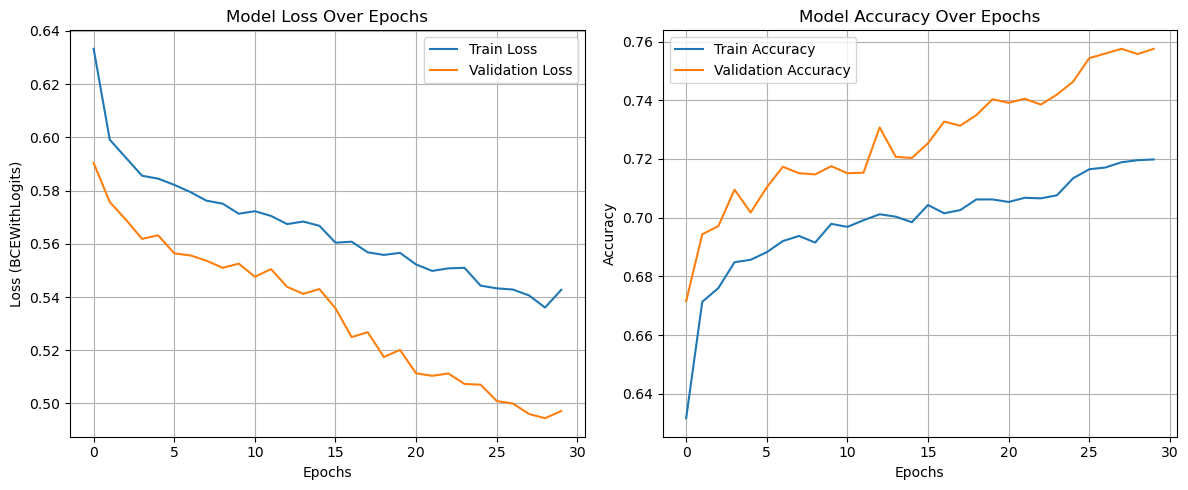

In [5]:
import torch.optim as optim
from sklearn.metrics import accuracy_score # Used for quick accuracy check during training

# Check if model and data loaders are available and properly initialized
if model and train_loader and val_loader:
    # Using BCEWithLogitsLoss is more numerically stable than Sigmoid + BCELoss
    criterion = nn.BCEWithLogitsLoss() 
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4) # AdamW is often preferred
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

    num_epochs = 30 # Adjust as needed based on convergence
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"\nStarting training on device: {device}")

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience_early_stopping = 10 # Stop if no improvement for this many epochs after best

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds_epoch, train_targets_epoch = [], []

        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]", leave=False):
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs_logits = model(features) # Model outputs raw logits
            loss = criterion(outputs_logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)
            
            # Get predictions (apply sigmoid then threshold)
            probs = torch.sigmoid(outputs_logits)
            predicted_classes = (probs > 0.5).float()
            train_preds_epoch.extend(predicted_classes.cpu().numpy().flatten())
            train_targets_epoch.extend(labels.cpu().numpy().flatten())

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = accuracy_score(train_targets_epoch, train_preds_epoch)
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_preds_epoch, val_targets_epoch = [], []
        with torch.no_grad():
            for features, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VALID]", leave=False):
                features, labels = features.to(device), labels.to(device)
                outputs_logits = model(features)
                loss = criterion(outputs_logits, labels)
                val_running_loss += loss.item() * features.size(0)

                probs = torch.sigmoid(outputs_logits)
                predicted_classes = (probs > 0.5).float()
                val_preds_epoch.extend(predicted_classes.cpu().numpy().flatten())
                val_targets_epoch.extend(labels.cpu().numpy().flatten())

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = accuracy_score(val_targets_epoch, val_preds_epoch)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        scheduler.step(epoch_val_loss) # Adjust LR based on validation loss

        # Early stopping and saving best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_drowsiness_model.pth')
            epochs_no_improve = 0
            print(f"Validation loss improved. Saved best model to 'best_drowsiness_model.pth'")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience_early_stopping:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {patience_early_stopping} epochs.")
            break
            
    print("\nTraining Finished!")

    # Load best model weights for final evaluation if early stopping occurred
    if os.path.exists('best_drowsiness_model.pth'):
        print("Loading best model weights for evaluation.")
        model.load_state_dict(torch.load('best_drowsiness_model.pth', map_location=device))

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (BCEWithLogits)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("Model or DataLoaders are not properly initialized. Skipping training.")

Evaluating on Test Set: 100%|██████████| 27/27 [00:00<00:00, 176.53it/s]



--- Test Set Evaluation Metrics ---
Accuracy:  0.7714
Precision (for Drowsy class): 0.7713
Recall (for Drowsy class):    0.8101
F1-Score (for Drowsy class):  0.7902

Classification Report:
                  precision    recall  f1-score   support

 Alert (Class 1)       0.77      0.81      0.79       895
Drowsy (Class 0)       0.77      0.73      0.75       789

        accuracy                           0.77      1684
       macro avg       0.77      0.77      0.77      1684
    weighted avg       0.77      0.77      0.77      1684



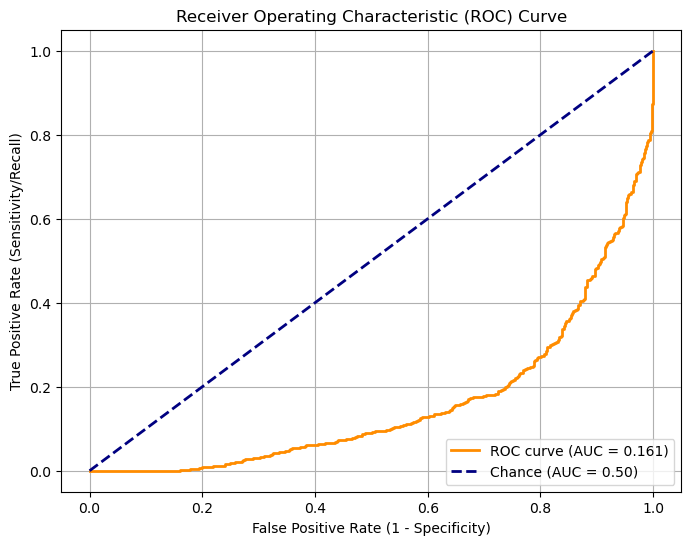

Area Under ROC Curve (AUC): 0.1614


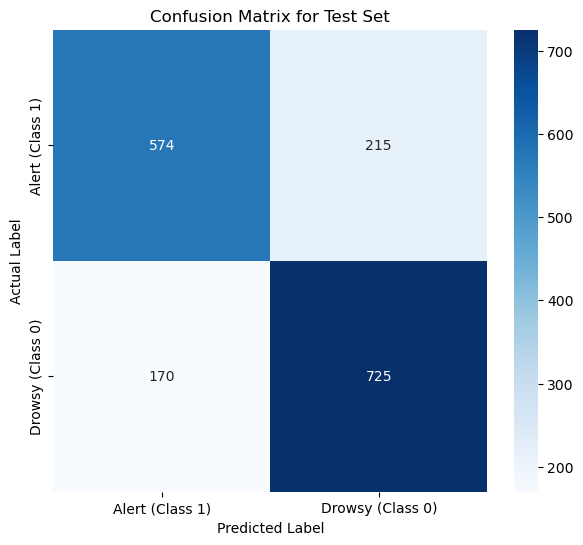

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns # For heatmap

# Ensure model is loaded and test_loader is available
if model and test_loader and 'device' in globals():
    model.eval() # Set model to evaluation mode
    
    all_test_targets = []
    all_test_pred_probs = [] # Store raw probabilities for ROC AUC
    all_test_pred_classes = [] # Store binarized predictions

    with torch.no_grad():
        for features, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            features, labels = features.to(device), labels.to(device)
            
            outputs_logits = model(features) # Get raw logits from the model
            probabilities = torch.sigmoid(outputs_logits) # Convert logits to probabilities
            predicted_classes = (probabilities > 0.5).float() # Binarize probabilities to 0 or 1

            all_test_targets.extend(labels.cpu().numpy().flatten())
            all_test_pred_probs.extend(probabilities.cpu().numpy().flatten())
            all_test_pred_classes.extend(predicted_classes.cpu().numpy().flatten())

    # Convert lists to numpy arrays for scikit-learn functions
    test_targets_arr = np.array(all_test_targets)
    test_pred_probs_arr = np.array(all_test_pred_probs)
    test_pred_classes_arr = np.array(all_test_pred_classes)

    # Calculate Core Metrics
    accuracy = accuracy_score(test_targets_arr, test_pred_classes_arr)
    # For binary classification, explicit pos_label=1 might be clearer if your labels are 0 and 1
    precision = precision_score(test_targets_arr, test_pred_classes_arr, pos_label=LABEL_DROWSY, zero_division=0)
    recall = recall_score(test_targets_arr, test_pred_classes_arr, pos_label=LABEL_DROWSY, zero_division=0)
    f1 = f1_score(test_targets_arr, test_pred_classes_arr, pos_label=LABEL_DROWSY, zero_division=0)

    print(f"\n--- Test Set Evaluation Metrics ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision (for Drowsy class): {precision:.4f}")
    print(f"Recall (for Drowsy class):    {recall:.4f}")
    print(f"F1-Score (for Drowsy class):  {f1:.4f}")

    print("\nClassification Report:")
    # Ensure target_names match your LABEL_ALERT and LABEL_DROWSY definitions
    target_names = [f'Alert (Class {LABEL_ALERT})', f'Drowsy (Class {LABEL_DROWSY})']
    print(classification_report(test_targets_arr, test_pred_classes_arr, target_names=target_names, zero_division=0))

    # ROC Curve and AUC
    # roc_curve expects true labels and prediction scores (probabilities of the positive class)
    fpr, tpr, thresholds = roc_curve(test_targets_arr, test_pred_probs_arr, pos_label=LABEL_DROWSY)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print(f"Area Under ROC Curve (AUC): {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(test_targets_arr, test_pred_classes_arr, labels=[LABEL_ALERT, LABEL_DROWSY])
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[target_names[0], target_names[1]],
                yticklabels=[target_names[0], target_names[1]])
    plt.title('Confusion Matrix for Test Set')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

else:
    print("Model, test_loader, or evaluation device not available. Skipping evaluation.")
    if not model: print("- Model is not initialized.")
    if not test_loader: print("- Test loader is not initialized.")
    if 'device' not in globals(): print("- Device (CPU/GPU) is not set.")